In [21]:
# Heterogeneous pooling
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from scipy import stats


from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from tqdm import tqdm





## Obtenção dos dados


In [22]:
df_origem = pd.read_csv('https://raw.githubusercontent.com/VitorBonella/PL-Dataset/main/dataset.csv',sep=";") #Leitura dos dados para o pandas

df_origem.set_index('id',inplace=True) #Transformando a coluna id no indice da tabela

#Observem que a classe esta separada em duas colunas então devemos concatenadas para formar uma coluna só chamada classe
df_origem['classe'] = df_origem['tipo_lampada'].str.replace(" ", "") + df_origem['potencia'].astype(str) 
classes = df_origem['classe']
# Lista de Indices
FOURIER = ['df01', 'df02', 'df03', 'df04','df05', 'df06', 'df07', 'df08', 'df09', 'df10']
HU = ['i1', 'i2', 'i3', 'i4','i5', 'i6', 'i7']
HARALICK = ['probmax', 'energia', 'entropia', 'contraste','homogeneidade', 'correlacao']
ALL = FOURIER + HU + HARALICK
df_origem[ALL] = df_origem[ALL].apply(lambda x: x.str.replace(',', '.').astype(float), axis=1)
df_origem = df_origem[FOURIER + HU]

X = df_origem.values
y = classes

In [23]:
# todos os dados serão armazenados neste dataframe, com o nome do método, acurácia média, desvio padrão, limite inferior e superior
df = pd.DataFrame(columns=['method', 'mean', 'std', 'lower', 'upper'])




## Execução dos modelos

In [24]:
# Zero Rule Baseline
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='most_frequent')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)

# cross validation
scoresZeroR = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

inf, sup = stats.norm.interval(0.95, loc=scoresZeroR.mean(), scale=scoresZeroR.std()/np.sqrt(len(scoresZeroR)))


df = df.append({'method': 'ZR', 'mean': scoresZeroR.mean(), 'std': scoresZeroR.std(), 'lower':inf, 'upper': sup}, ignore_index=True)


In [25]:
# Função para treinar os modelos e retornar o dataframe com os resultados e os scores
def train_model(model,params_grid,name, df): 
    scalar = StandardScaler()
    pipe = Pipeline(steps=[('s',scalar), ('m', model)])

    outer = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)
    inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=36851234)

    gs = GridSearchCV(pipe, param_grid=params_grid, scoring='accuracy', cv=inner, n_jobs=-1)

    scores = cross_val_score(gs, X, y.values.ravel(), scoring='accuracy', cv=outer, n_jobs=-1)
    

    inf, sup = stats.norm.interval(0.95, loc=scores.mean(), scale=scores.std()/np.sqrt(len(scores)))

    df_awnser = pd.concat([df, pd.DataFrame({'method': [name], 'mean': [np.mean(scores)],'std':[np.std(scores)], 'lower': inf, 'upper': sup})], ignore_index=True)
    
    return df_awnser, scores

In [26]:
from sklearn.ensemble import BaggingClassifier


bg = BaggingClassifier(random_state=11)

name = 'BA'

params_grid = {
    'm__n_estimators': [3,9,15,21]
    } 

df, scoresBagging = train_model(bg,params_grid,name,df)


In [27]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(random_state=11)

name = 'AB'

params_grid = {
    'm__n_estimators': [3,9,15,21]
    }

df,scoresAda = train_model(ada,params_grid,name,df)

In [28]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(random_state=11)

name = 'RF'

params_grid = {
    'm__n_estimators': [3,9,15,21]
} 


df,scoresRandomForest = train_model(rf,params_grid,name,df)

### HP

In [30]:
# import base estimators
from sklearn.base import BaseEstimator
# import classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


class HeterogeneousEnsemble(BaseEstimator):
    # define o construtor para o classificador
    def __init__(self,n_samples=3):
        
        self.classifiers  =  [DecisionTreeClassifier(random_state=11), KNeighborsClassifier(), GaussianNB()]
        self.n_samples = n_samples
        self.trained_classifiers = []


    def train_classifiers(self, X, y):

        # converter para numpy array
        X = X.to_numpy()
        y = y.to_numpy()

        # faz o loop sobre os classificadores individuais
        for clf in self.classifiers:
            # treina o classificador no conjunto de treinamento atual
            clf.fit(X, y.ravel())
            # adiciona o classificador treinado à lista
            self.trained_classifiers.append(clf)
        # retorna a lista de classificadores treinados
        return self.trained_classifiers

    def sample_data(self,X, y, random_state):
        # amostra as características com reposição e obtém os rótulos correspondentes
        X_sampled = X.sample(frac=1, replace=True, random_state=random_state)
        y_sampled = y.loc[X_sampled.index]
        # retorna o conjunto de dados amostrado
        return X_sampled, y_sampled


    def predict_hp(self, X_test, class_order):
        # cria um dicionário para armazenar as predições de cada classificador
        votes = {}
        X_test = X_test.to_numpy().reshape(1, -1)
        # faz o loop sobre os classificadores individuais
        for clf in self.trained_classifiers:
            # prediz a classe do exemplo de teste usando o classificador atual
            pred = clf.predict(X_test)
            # armazena a predição no dicionário
            if pred[0] in votes:
                votes[pred[0]] += 1
            else:
                votes[pred[0]] = 1
                

        # obtém a(s) classe(s) mais votada(s) e as armazena em uma lista
        max_votes = max(votes.values())
        most_voted_classes = [k for k,v in votes.items() if v == max_votes]
        
        hp_pred = None

        # se houver mais de uma classe mais votada, quebra o empate usando a ordem das classes do conjunto de treinamento
        if len(most_voted_classes) > 1:
            for c in class_order:
                if c in most_voted_classes:
                    hp_pred = c
                    break
            if hp_pred is None:
                hp_pred = most_voted_classes[0]
        # caso contrário, retorna a classe mais votada como a predição do conjunto HP
        else:
            hp_pred = most_voted_classes[0]

        # retorna a predição
        return hp_pred



    def fit(self,X,y): 

        # se os dados forem uma matriz numpy, converta para dataframe pandas
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        if isinstance(y, np.ndarray):
            y = pd.Series(y)

        # reset index
        X.reset_index(drop=True, inplace=True)
        y.reset_index(drop=True, inplace=True)

        classifiers = [] # ciclo para treinar os classificadores individuais
        for i in range(self.n_samples):
            # se for a primeira iteração, use os dados de treinamento originais
            if i == 0:
                X_current = X.copy()
                y_current = y.copy()
            # caso contrário, crie um novo conjunto de treinamento amostrando com reposição os dados originais usando a função sample_data
            else:
                X_current, y_current = self.sample_data(X, y, i)
            
            # treina os classificadores individuais nos dados de treinamento atuais usando a função train_classifiers e os estende à lista
            classifiers.extend(self.train_classifiers(X_current, y_current))

    def predict(self,X_test): 
        if(isinstance(X_test, np.ndarray)):
            X_test = pd.DataFrame(X_test)
        
        class_order = y.value_counts().index.tolist()
        # cria uma lista vazia para armazenar as predições do conjunto HP
        hp_predictions = []
        # faz o loop sobre os exemplos de teste
        for index, row in X_test.iterrows():
            # prediz a classe do exemplo de teste usando a função predict_hp e a adiciona à lista
            hp_pred = self.predict_hp(row, class_order)
            hp_predictions.append(hp_pred)
        return hp_predictions

    

In [31]:

# incializa o classificador
hp = HeterogeneousEnsemble()

name = 'HP'

params_grid = {
    'm__n_samples': [1,3,5,7]
    }

df, scoresHeteros = train_model(hp,params_grid,name,df)



In [32]:
df


,method,mean,std,lower,upper
0,ZR,0.165057,0.010883,0.161163,0.168952
1,BA,0.511073,0.106405,0.472997,0.549148
2,AB,0.271648,0.033420,0.259689,0.283606
3,RF,0.515517,0.091542,0.482760,0.548274
4,HP,0.421341,0.078885,0.393113,0.449569


In [33]:
df.to_csv('df.csv', index=False)

## Testes e gráficos


In [34]:
from scipy import stats 
# ttest and wilcoxon test

scores = [scoresZeroR, scoresBagging, scoresAda, scoresRandomForest, scoresHeteros]
models_names = ['ZeroR', 'BG', 'AB', 'RF', 'HP']

comparative_results = {}

for i in range(len(scores)):
    for j in range(i+1, len(scores)):
        # ttest
        ttest = stats.ttest_rel(scores[i], scores[j])
        # wilcoxon
        wilcoxon = stats.wilcoxon(scores[i], scores[j])
        # save results
        comparative_results[models_names[i] + ' x ' + models_names[j]] = [ttest, wilcoxon]
        


# tabela com os resultados dos testes, t student no superior e wilcoxon no inferior
table = pd.DataFrame(columns=models_names, index=models_names)

for i in range(len(models_names)):
    for j in range(i, len(models_names)):
        # se o index for igual a coluna 
        if i == j:
            table.loc[models_names[i], models_names[j]] = models_names[i]

        else:
            table.loc[models_names[i], models_names[j]] = comparative_results[models_names[i] + ' x ' + models_names[j]][0][1]
            table.loc[models_names[j], models_names[i]] = comparative_results[models_names[i] + ' x ' + models_names[j]][1][1]


table.to_csv('tstudent_wilcoxon.csv', index=False)



/usr/local/lib/python3.8/dist-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [35]:
table

,ZeroR,BG,AB,RF,HP
ZeroR,ZeroR,0.0,0.0,0.0,0.0
BG,0.0,BG,0.0,0.719459,0.0
AB,0.0,0.0,AB,0.0,0.0
RF,0.0,0.590977,0.0,RF,0.0
HP,0.0,0.000008,0.000003,0.000013,HP


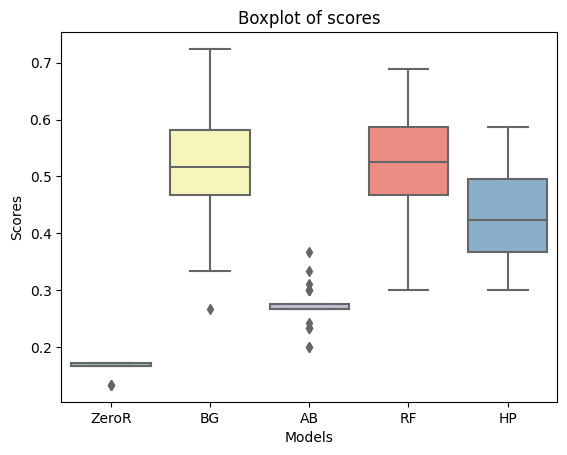

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
#box plot of scores 
sns.boxplot(data=scores, palette="Set3").set(xticklabels=models_names)
plt.title('Boxplot of scores')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.savefig('boxplot_scores.png')
